In [29]:
%load_ext autoreload
%autoreload 2

import eos
import pyhf
import json
import yaml
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyzing `pyhf` likelihoods with `EOS`

In this example notebook we demonstrate how to use the nested sampling capabilities of `EOS` to sample from `pyhf` statistical models. The priors can be set in the `eos. In the `eos.AnalysisFile` we specify
- the `pyhf` **likelihood**
  - `file`: the `pyhf` workspace in `JSON` format
  - `parameter_map`: a dictionary from `pyhf` parameters to `EOS` parameters in case you want to rename parameters. A "pyhf::" prefix is automatically added to the parameters.
- the **priors** of unconstrained parameters of the modelAnalysisFile` `YAML` format. Constrained parameters are automatically assigned the corresponding priors.

## Uncorrelated backgrounds

We start with an uncorrelated background uncertainty `pyhf.simplemodels` model and save it to `JSON` format.

In [219]:
model = pyhf.simplemodels.uncorrelated_background(
            signal=[5.0, 10.0], bkg=[50.0, 60.0], bkg_uncertainty=[5.0, 6.0]
        )

data = [60., 80.]

workspace = pyhf.Workspace.build(model, data)

with open('workspace_uncorr.json', 'w') as f:
    json.dump(workspace, f, indent=2)

workspace.model().spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [5.0, 10.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background',
     'data': [50.0, 60.0],
     'modifiers': [{'name': 'uncorr_bkguncrt',
       'type': 'shapesys',
       'data': [5.0, 6.0]}]}]}],
 'parameters': [{'bounds': [[0, 10]],
   'inits': [1.0],
   'fixed': False,
   'name': 'mu'},
  {'bounds': [[1e-10, 10.0], [1e-10, 10.0]],
   'inits': [1.0, 1.0],
   'fixed': False,
   'name': 'uncorr_bkguncrt'}]}

In the `eos.AnalysisFile` we specify the `pyhf` workspace in terms of a `JSON` file. In addtion, we der the prior of the signal strength to a be uniform in the range -2 to 6.

In [224]:
analysis_file = "pyhf_uncorr.yaml"
with open(analysis_file) as input_file:
    input_data = yaml.load(input_file, Loader=yaml.SafeLoader)

input_data

{'priors': [{'name': 'EXP-pyhf-params',
   'descriptions': [{'parameter': 'pyhf::mu',
     'min': -2,
     'max': 6,
     'type': 'uniform'}]}],
 'likelihoods': [{'name': 'EXP-pyhf',
   'pyhf': {'file': 'workspace_uncorr.json'}}],
 'posteriors': [{'name': 'EXP-pyhf-posterior',
   'prior': ['EXP-pyhf-params'],
   'likelihood': ['EXP-pyhf']}]}

We read in the analysis file and confirm the correct priors by investigating the `eos.analysis.Analysis` object:

In [225]:
af = eos.AnalysisFile(analysis_file)
af.analysis('EXP-pyhf-posterior')

As a cross-check we can compare the best-fit-point of the log(posterior) with the `pyhf` fit:

In [226]:
af.analysis('EXP-pyhf-posterior').optimize()

/home/lorenz/micromamba/envs/eos-dev/lib/python3.10/site-packages/pyhf/tensor/numpy_backend.py:439: RuntimeWarning: invalid value encountered in subtract
  return xlogy(n, lam) - lam - gammaln(n + 1.0)  # type: ignore[no-any-return]


parameter,value
mu,2.0000
uncorr_bkguncrt[0],1.0000
uncorr_bkguncrt[1],1.0000


In [227]:
pyhf.infer.mle.fit(data + model.config.auxdata, model)

array([1.99996869, 0.99999252, 0.9999971 ])

Lastly, we make use of the nested sampling capabilities of `EOS` to sample from the likelihood, given the specified priors:

In [228]:
eos.tasks.sample_nested(af, 'EXP-pyhf-posterior')

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('EXP-pyhf-posterior/nest…

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('EXP-pyhf-posterior/plot…

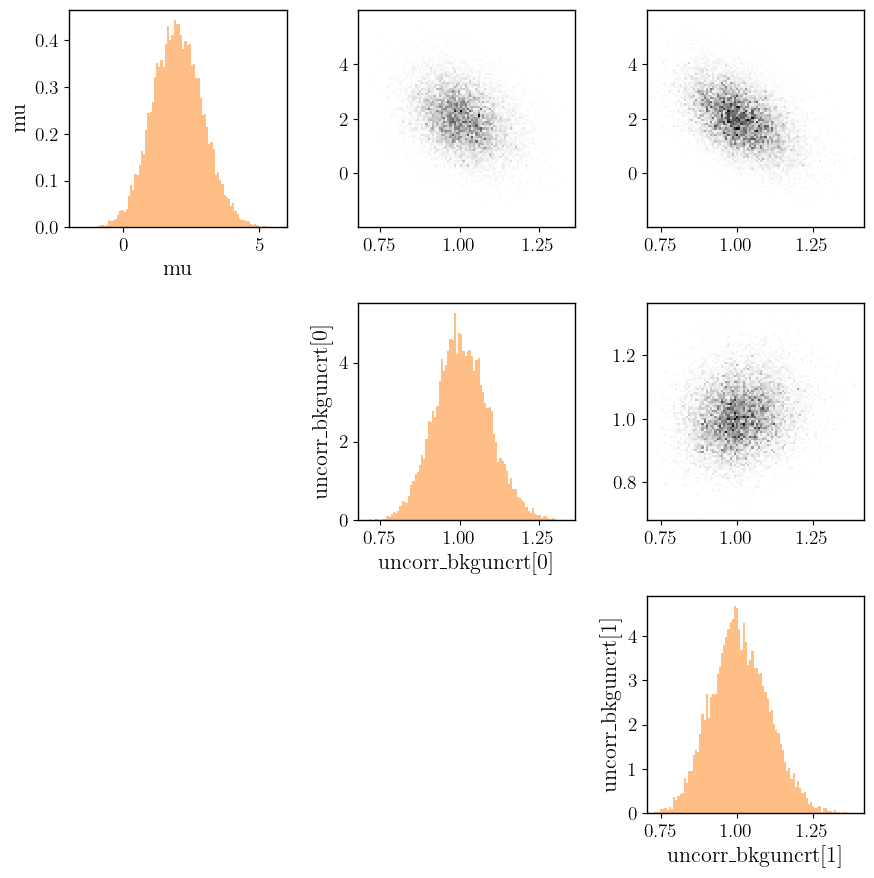

In [229]:
eos.tasks.corner_plot(af, 'EXP-pyhf-posterior')

We see, the signal strength "mu", peaks at the expected value of 2, whereas the background uncertainties peak at their initial values.

# Correlated backgrounds

We repeat the above example with a correlated background uncertainty `pyhf.simplemodels` model.

In [230]:
model = pyhf.simplemodels.correlated_background(
            signal=[5.0, 0.0], bkg=[50.0, 60.0], bkg_down=[50.0, 55.0], bkg_up=[50.0, 70.0]
        )

data = [60., 65.]

workspace = pyhf.Workspace.build(model, data)

with open('workspace_corr.json', 'w') as f:
    json.dump(workspace, f, indent=2)

workspace.model().spec

{'channels': [{'name': 'single_channel',
   'samples': [{'name': 'signal',
     'data': [5.0, 0.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None}]},
    {'name': 'background',
     'data': [50.0, 60.0],
     'modifiers': [{'name': 'correlated_bkg_uncertainty',
       'type': 'histosys',
       'data': {'hi_data': [50.0, 70.0], 'lo_data': [50.0, 55.0]}}]}]}],
 'parameters': [{'bounds': [[-5.0, 5.0]],
   'inits': [0.0],
   'fixed': False,
   'name': 'correlated_bkg_uncertainty'},
  {'bounds': [[0, 10]], 'inits': [1.0], 'fixed': False, 'name': 'mu'}]}

Now we add a `parameter_map` to rename "mu" to "pyhf::signal_strength":

In [231]:
analysis_file = "pyhf_corr.yaml"
with open(analysis_file) as input_file:
    input_data = yaml.load(input_file, Loader=yaml.SafeLoader)

input_data

{'priors': [{'name': 'EXP-pyhf-params',
   'descriptions': [{'parameter': 'pyhf::signal_strength',
     'min': -2,
     'max': 6,
     'type': 'uniform'}]}],
 'likelihoods': [{'name': 'EXP-pyhf',
   'pyhf': {'file': 'workspace_corr.json',
    'parameter_map': {'mu': 'pyhf::signal_strength'}}}],
 'posteriors': [{'name': 'EXP-pyhf-posterior',
   'prior': ['EXP-pyhf-params'],
   'likelihood': ['EXP-pyhf']}]}

In [232]:
af = eos.AnalysisFile("pyhf_corr.yaml")
test = af.analysis('EXP-pyhf-posterior')
test

We cross-check the best-fit-point of the log(posterior) with the `pyhf` fit:

In [233]:
test.optimize()

/home/lorenz/micromamba/envs/eos-dev/lib/python3.10/site-packages/pyhf/tensor/numpy_backend.py:439: RuntimeWarning: invalid value encountered in subtract
  return xlogy(n, lam) - lam - gammaln(n + 1.0)  # type: ignore[no-any-return]


parameter,value
mu,2.0000
correlated_bkg_uncertainty,0.3305


In [234]:
pyhf.infer.mle.fit(data + model.config.auxdata, model)

array([0.33045059, 1.99999901])

Lastly, we sample again from the likelihood, given the specified priors:

In [235]:
eos.tasks.sample_nested(af, 'EXP-pyhf-posterior')

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('EXP-pyhf-posterior/nest…

Accordion(children=(Output(layout=Layout(height='200px', overflow='auto')),), titles=('EXP-pyhf-posterior/plot…

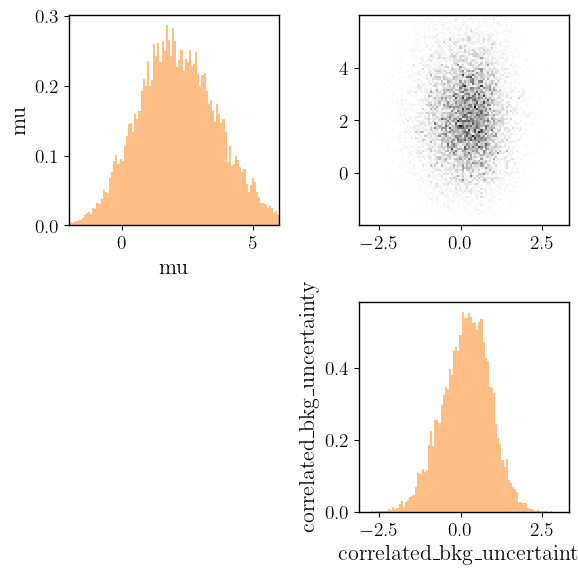

In [236]:
eos.tasks.corner_plot(af, 'EXP-pyhf-posterior')

The signal strength "mu", peaks at the expected value of 2, whereas the background uncertainties peak at their initial values.